## Import Req'd Libraries 

In [1]:
import pandas as pd
import os
import seaborn as sns

In [2]:
#Getting all the file_names in a given directory
def get_file_names(folder):
    #Listing entries present in given folder
    entries = os.listdir(folder)
    for i in entries:
        if 'csv' not in i:
            entries.remove(i)
    return sorted(entries, reverse=True)

#Saving the file
def save_file(root, name_of_file, my_dataframe):
    #Test if save directory exists
    try:
        my_dataframe.to_csv(root+'processed_data/'+ name_of_file, index=False)
    #Otherwise make the directory and then save
    except:
        os.mkdir(root+'processed_data')
        my_dataframe.to_csv(root+'processed_data/'+ name_of_file, index=False)

In [3]:
def initialization(filepath):
    df = pd.read_csv(filepath, 
                     usecols = ['id','last_scraped', 'host_is_superhost', 
                            'latitude','longitude', 'property_type',
                           'room_type','accommodates','bathrooms',
                           'bedrooms','beds','amenities', 'price',
                            'instant_bookable','cancellation_policy'])
    df["last_scraped"] = pd.to_datetime(df["last_scraped"])
    df["price"] = df["price"].apply(lambda x: x.replace('$','').replace(',', '').replace('.00', '')).astype("int")
    return df

## Concatenating All Data Together

In [4]:
# get list of filenames
root = '../'
name = get_file_names(root+'original_dataset')
accum_kept = 0
accum_removed = 0

# combine all files into one
print("COMBINING INTO ONE DATAFRAME...")
frames = []
for i in name:
    print("--Processing: ", i)
    filepath = root+'original_dataset/'+i
    frames.append(initialization(filepath))
full_df = pd.concat(frames, sort=False)

initial_samples = len(full_df)
print("Initial # of Samples: ", len(full_df))

print(" ")

# Drop missing values
print("DELETING SAMPLES WITH MISSING VALUES...")
full_df = full_df.dropna()
samples1 = len(full_df)
print("--Number of Samples Removed: ", initial_samples-samples1)

# reset index
full_df = full_df.reset_index(drop=True)

COMBINING INTO ONE DATAFRAME...
--Processing:  19_08_08_listings.csv
--Processing:  19_07_08_listings.csv
--Processing:  19_06_04_listings.csv
--Processing:  19_05_06_listings.csv
--Processing:  19_04_08_listings.csv
--Processing:  19_03_07_listings.csv
--Processing:  19_02_04_listings.csv
--Processing:  19_01_13_listings.csv
--Processing:  18_12_06_listings.csv
--Processing:  18_11_04_listings.csv
--Processing:  18_10_06_listings.csv
--Processing:  18_09_08_listings.csv
Initial # of Samples:  236507
 
DELETING SAMPLES WITH MISSING VALUES...
--Number of Samples Removed:  559


## Numericalize Categorical Data

#### Mapping for Categorical Features

In [5]:
cancellation_policies = {
    "flexible": 1,
    "moderate": 5,
    "strict_14_with_grace_period": 14,
    "super_strict_30": 30,
    "super_strict_60": 60
}
room_types = {
    "Entire home/apt": 0,
    "Private room": 1,
    "Shared room": 2
}
true_false = {
    't': 1,
    'f': 0,
    True: 1,
    False: 0
}

In [6]:
# convert t/f into 1/0
print("NUMERICALIZING TRUE/FALSE...")
for i in ["host_is_superhost", "instant_bookable"]:
    full_df[i] = full_df[i].map(true_false)
    print(full_df[i].value_counts())

print(" ")

# cancellation policy
print("NUMERICALIZING CANCELLATION POLICY...")
print(full_df["cancellation_policy"].value_counts())
full_df["cancellation_policy"] = full_df["cancellation_policy"].map(cancellation_policies)

print(" ")

# room_type
print("NUMERICALIZING ROOM TYPE...")
print(full_df["room_type"].value_counts())
full_df["room_type"] = full_df["room_type"].map(room_types)


NUMERICALIZING TRUE/FALSE...
0    175881
1     60067
Name: host_is_superhost, dtype: int64
0    147446
1     88502
Name: instant_bookable, dtype: int64
 
NUMERICALIZING CANCELLATION POLICY...
strict_14_with_grace_period    93976
moderate                       70987
flexible                       70497
super_strict_30                  345
super_strict_60                  143
Name: cancellation_policy, dtype: int64
 
NUMERICALIZING ROOM TYPE...
Entire home/apt    152229
Private room        79583
Shared room          4136
Name: room_type, dtype: int64


#### Mapping for Property Types

In [7]:
property_types = {
    "House" : 1,
    "Apartment" : 2,
    "Condominium" : 5,
    "Townhouse" : 3,
    "Bungalow" : 0,
    "Loft" : 4,
    "Serviced Apartment" : 6,
    "Guest Suite" : 7
}

In [8]:
print("FILTERLING AND NUMERICALIZING PROPERTY TYPES...")
property_type_counts = full_df["property_type"].value_counts()
accum = []
for i in range(len(property_type_counts)):
    if property_type_counts[i] >= 0.01*samples1:
        accum.append(property_type_counts.index[i])
print("Types of Included Properties:")
print(accum)

full_df = full_df[full_df["property_type"].isin(accum)]
print(full_df["property_type"].value_counts())

full_df["property_type"] = full_df["property_type"].map(property_types)

samples2 = len(full_df)
print("Number of Samples Removed:", samples1 - samples2)
full_df = full_df.reset_index(drop=True)

FILTERLING AND NUMERICALIZING PROPERTY TYPES...
Types of Included Properties:
['Apartment', 'House', 'Condominium', 'Townhouse', 'Guest suite', 'Bungalow', 'Loft', 'Serviced apartment']
Apartment             73132
House                 62791
Condominium           59341
Townhouse             11401
Guest suite            8561
Bungalow               7278
Loft                   5268
Serviced apartment     2676
Name: property_type, dtype: int64
Number of Samples Removed: 5500


## Store Mean and Std Dev

In [9]:
mean_std = pd.DataFrame(columns = ["mean", "std"])

## Normalizing Price

In [10]:
print("(BEFORE) PRICE STATISTICS...")
print(full_df["price"].describe())
print(full_df["price"].quantile([0.01, 0.05, 0.1, 0.9, 0.95, 0.99]))

print("")
print("TRIMMING PRICE OUTLIERS...")
min_price = full_df["price"].quantile(0.05)
max_price = full_df["price"].quantile(0.95)

full_df = full_df[(full_df["price"] >= min_price) & (full_df["price"] <= max_price)]
samples3 = len(full_df)
print("--Number of Samples Removed: ", samples2-samples3)
full_df = full_df.reset_index(drop=True)

print("")
print("STANDARDIZING PRICE...") # using Z-score
mean_price = full_df["price"].mean()
std_price = full_df["price"].std()
full_df["price"] = (full_df["price"] - mean_price)/std_price
print("--Mean Price: ", mean_price)
print("--Std Price: ", std_price)
temp = pd.DataFrame([[mean_price, std_price]], columns=["mean", "std"], index=["price"])
mean_std = mean_std.append(temp)

(BEFORE) PRICE STATISTICS...
count    230448.000000
mean        141.131253
std         222.025238
min           0.000000
25%          65.000000
50%         100.000000
75%         160.000000
max       13426.000000
Name: price, dtype: float64
0.01     25.0
0.05     35.0
0.10     43.0
0.90    250.0
0.95    350.0
0.99    700.0
Name: price, dtype: float64

TRIMMING PRICE OUTLIERS...
--Number of Samples Removed:  20833

STANDARDIZING PRICE...
--Mean Price:  120.09710182954464
--Std Price:  68.1989415678001


## Categorizing Amenities

In [11]:
amenities = ['Kitchen', 'Heating', 'Washer', 'Wifi', 'Indoor fireplace', 'Iron', 
             'Laptop friendly workspace', 'Crib', 'Self check-in', 'Carbon monoxide detector', 
             'Shampoo', 'Air conditioning', 'Dryer', 'Breakfast', 'Hangers', 'Hair dryer', 
             'TV', 'High chair', 'Smoke detector', 'Private bathroom']

facilities = ['Free parking on premises', 'Gym', 'Hot tub', 'Pool']

house_rules = ['Suitable for events', 'Pets allowed', 'Smoking allowed']

In [12]:
for i in amenities:
    full_df["amenities_"+i] = full_df["amenities"].apply(lambda x: 1 if i in x else 0)
full_df["amenities_count"] = sum(full_df["amenities_"+i] for i in amenities)

for i in facilities:
    full_df["facilities_"+i] = full_df["amenities"].apply(lambda x: 1 if i in x else 0)
full_df["facilities_count"] = sum(full_df["facilities_"+i] for i in facilities)

for i in house_rules:
    full_df["house_rules_"+i] = full_df["amenities"].apply(lambda x: 1 if i in x else 0)
full_df["house_rules_count"] = sum(full_df["house_rules_"+i] for i in house_rules)

## Standardizing Numerical Features


In [13]:
for i in ["latitude", "longitude", "property_type", "room_type", "accommodates", "bathrooms", "bedrooms", "beds", "cancellation_policy", "amenities_count", "facilities_count", "house_rules_count"]:
    print("STANDARDIZING "+i.upper()+"...")
    mean = full_df[i].mean()
    std = full_df[i].std()
    temp = pd.DataFrame([[mean, std]], columns=["mean", "std"], index=[i])
    mean_std = mean_std.append(temp)
    full_df[i] = (full_df[i] - mean)/std
    print("--Mean: ", mean)
    print("--Std: ", std)
    print("")

STANDARDIZING LATITUDE...
--Mean:  43.6774921041365
--Std:  0.04610974980603515

STANDARDIZING LONGITUDE...
--Mean:  -79.398326263056
--Std:  0.059359153647078375

STANDARDIZING PROPERTY_TYPE...
--Mean:  2.602684638072134
--Std:  1.635305987842257

STANDARDIZING ROOM_TYPE...
--Mean:  0.340686496672471
--Std:  0.49595747276278074

STANDARDIZING ACCOMMODATES...
--Mean:  3.053679364549293
--Std:  1.762131516737716

STANDARDIZING BATHROOMS...
--Mean:  1.200374496099993
--Std:  0.45931966657010054

STANDARDIZING BEDROOMS...
--Mean:  1.2703432483362356
--Std:  0.7651023775852693

STANDARDIZING BEDS...
--Mean:  1.6253655511294516
--Std:  0.9610655274398833

STANDARDIZING CANCELLATION_POLICY...
--Mean:  7.400939818238198
--Std:  5.685699314132479

STANDARDIZING AMENITIES_COUNT...
--Mean:  12.185917038379888
--Std:  2.775617813711928

STANDARDIZING FACILITIES_COUNT...
--Mean:  1.0651384681439782
--Std:  1.1810710269788807

STANDARDIZING HOUSE_RULES_COUNT...
--Mean:  0.18460988001812847
--Std:  

## Split Dataset and Save

In [14]:
train_df = full_df.sample(frac=0.8,random_state=200) #random state is a seed value
val_test_df = full_df.drop(train_df.index)
val_df = val_test_df.sample(frac=0.5,random_state=200) #random state is a seed value
test_df = val_test_df.drop(val_df.index)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [16]:
train_df.to_csv("../split_datasets/train.csv", index=False)
val_df.to_csv("../split_datasets/val.csv", index=False)
test_df.to_csv("../split_datasets/test.csv", index=False)

In [17]:
print("Total # of Samples Remaining:\t", len(full_df))
print("Number of Samples Removed:\t", initial_samples - len(full_df))
print("% of Samples Removed:\t\t", (initial_samples - len(full_df))/initial_samples*100.0)
print("Number of Train Samples:\t", len(train_df))
print("Number of Val Samples:\t\t", len(val_df))
print("Number of Test Samples:\t\t", len(test_df))

Total # of Samples Remaining:	 209615
Number of Samples Removed:	 26892
% of Samples Removed:		 11.370487977100044
Number of Train Samples:	 167692
Number of Val Samples:		 20962
Number of Test Samples:		 20961


In [18]:
mean_std.to_csv("mean_std.csv")

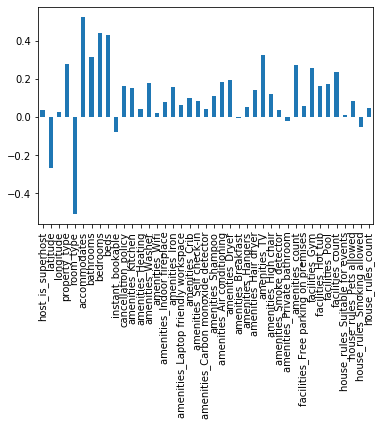

In [19]:
corr = full_df.corrwith(full_df["price"]).drop(["id", "price"])
corr.plot.bar()